In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.nn.utils.rnn import pack_padded_sequence

import aeye
from aeye.trainUtils import trainIters, train
from aeye.preprocessing import Lang


In [3]:
vocab = aeye.load_vocab('train_vocab.pkl')

In [4]:
vocab('jith')

3

In [5]:
ann_file = '/home/jithin/datasets/imageCaptioning/captions/dataset_flickr8k.json'
img_files = '/home/jithin/datasets/imageCaptioning/flicker8k/Flicker8k_Dataset/'

transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),        
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

dataset_train = aeye.Flickr8k(img_dir=img_files,
                        ann_file=ann_file,
                        vocab=vocab,
                        split='train',
                        transform=transform)

dataset_test = aeye.Flickr8k(img_dir=img_files,
                        ann_file=ann_file,
                        vocab=vocab,
                        split='test',
                        transform=transform)

dataset_val = aeye.Flickr8k(img_dir=img_files,
                        ann_file=ann_file,
                        vocab=vocab,
                        split='val',
                        transform=transform)

trainDataloader = torch.utils.data.DataLoader(dataset = dataset_train,
                                   batch_size = 10,
                                   shuffle = True,
                                   num_workers = 0,
                                   collate_fn = aeye.collate_fn)

testDataloader = torch.utils.data.DataLoader(dataset = dataset_test,
                                   batch_size = 10,
                                   shuffle = True,
                                   num_workers = 1,
                                   collate_fn = aeye.collate_fn)

# valDataloader will not work because the sentences are not padded
# and are of different lengths.

loading train complete
loading test complete
loading val complete


In [52]:
 class DecoderLSTM_SchedSamp(nn.Module):
    def __init__(self, hidden_size, output_size, batch_size, device, num_layers = 1):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.device = device

        self.embeddings = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)
 
    def forward(self, img_vec, captions, lengths):
        hidden = self.initHidden(img_vec)
        output = self.embeddings(captions)
        output = F.relu(output)
        output = torch.nn.utils.rnn.pack_padded_sequence(output, lengths)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output.data)
 
        return output, hidden

    def sample(self, img_vec, max_length=30):
        samples = list()
        
        # Check if image batch_size is 1
        assert img_vec.size(0) == 1
        hidden = self.initHidden(img_vec, batch_size=1)
        input_cap = torch.tensor([1]).long().unsqueeze(0)
        input = self.embeddings(input_cap)
        input = F.relu(input)
        for i in range(max_length):
            output, hidden = self.lstm(input, hidden)
            output = self.out(output)
            
            samples.append(output.topk(1).indices.item())
            
        
        return samples
    
    def initHidden(self, img_vec, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        
        img_vec = img_vec.unsqueeze(0)
        assert img_vec.shape == (self.num_layers, batch_size, self.hidden_size)
        return (img_vec, torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device))


In [53]:
batch_size = int(len(dataset_train)/len(trainDataloader))*5

In [17]:
from aeye.models import Encoder
from aeye.models import DecoderLSTM
from train import eval_loss


device = torch.device('cuda')
hidden_size = 512
batch_size = int(len(dataset_train)/len(trainDataloader))*5

decoder = DecoderLSTM(hidden_size, vocab.n_words, 50, device)
encoder = Encoder(hidden_size)
encoder, decoder


(Encoder(
   (resnet): Sequential(
     (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (4): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [18]:
epochs = 200
criterion = nn.CrossEntropyLoss()
decoder_optimizer = optimizer = optim.SGD(decoder.parameters(), lr=0.001)

for epoch in range(epochs):
    # train 1 epoch
    print('[Epoch: %d / %d]'%(epoch+1, epochs))
    print_losses, plot_losses = trainIters(testDataloader,
                                           encoder.to(device),
                                           decoder.to(device), 
                                           device,
                                           criterion,
                                           print_every=50)
    
    print('[Epoch] Training Loss: %.4f'%(sum(print_losses)/len(print_losses)))
    
    print('[Epoch] Running Eval')
    eval_losss = eval_loss(testDataloader,
                            encoder.to(device),
                            decoder.to(device),
                            criterion,
                            device)
    print('[Epoch] Eval loss: %.4f'%(eval_losss))
    
    print('Epoch] Running sampler')
    predict(dataset_val,encoder, decoder, device, vocab)    

[Epoch: 1 / 200]
0m 9s (- 0m 9s) (49 49%) 9.0332
0m 18s (- 0m 0s) (99 99%) 9.0060
[Epoch] Training Loss: 9.0196
[Epoch] Running Eval


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]

[Epoch] Eval loss: 8.9934
Epoch] Running sampler
bikins taxis coasting propelling balconies poofy pastels propelling balconies poofy pastels propelling balconies poofy pastels propelling balconies poofy pastels propelling balconies poofy pastels propelling balconies poofy pastels propelling balconies poofy ['SOS a football player tries diving after another player EOS', 'SOS a pro football player tackles another player on the goal line in a crowded stadium EOS', 'SOS football player in white and purple uniform with legs being tackled by player in red and white uniform EOS', 'SOS football player tackling another player in a football game EOS', 'SOS the red football player is grabbing the purple and white player s leg to try and stop him EOS']
[Epoch: 2 / 200]


0m 9s (- 0m 9s) (49 49%) 8.9806
0m 18s (- 0m 0s) (99 99%) 8.9546
[Epoch] Training Loss: 8.9676
[Epoch] Running Eval


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]

[Epoch] Eval loss: 8.9410
Epoch] Running sampler
SOS toilet mudfight painted uno fisheye know kisses kisses parking EOS EOS EOS EOS EOS EOS roadside dumbbell kisses cars kisses conversation corgie glass glass snowboarders fisheye EOS EOS EOS ['SOS a blue and grey race car driving on a dirt track EOS', 'SOS a person driving a drag racer on dirt EOS', 'SOS a person is in a race car on a track with a lot debri EOS', 'SOS a race car driver is driving his car through the mud EOS', 'SOS the blue and gray vehicle is racing through the gravel EOS']
[Epoch: 3 / 200]


0m 9s (- 0m 9s) (49 49%) 8.9268
0m 18s (- 0m 0s) (99 99%) 8.9024
[Epoch] Training Loss: 8.9146
[Epoch] Running Eval


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]

[Epoch] Eval loss: 8.8872
Epoch] Running sampler
SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS ['SOS a man in a suit along the railing of a balcony that has a very high view EOS', 'SOS a man stands alone near a white fence EOS', 'SOS a man stands and reads something by a railing overlooking a town EOS', 'SOS a man stands at the end of a pier reading a book against a blue sky EOS', 'SOS man is standing next to the railing with beautiful clouds in the background EOS']
[Epoch: 4 / 200]


0m 9s (- 0m 9s) (49 49%) 8.8749
0m 18s (- 0m 0s) (99 99%) 8.8453
[Epoch] Training Loss: 8.8601
[Epoch] Running Eval


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]

[Epoch] Eval loss: 8.8318
Epoch] Running sampler
SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS ['SOS a dirt bike rider holds up his finger EOS', 'SOS a man wearing a sponsor covered motorcycling suit sits on a motorbike raising his hand EOS', 'SOS a motorcycle racer is gesturing at somebody EOS', 'SOS a race car driver stands up with his hand pointing in the air EOS', 'SOS the person in the blue jacket has a colorful helmet on EOS']
[Epoch: 5 / 200]


KeyboardInterrupt: 

## Building Dataloader

In [111]:
from aeye.datasets import Flickr8k
from aeye.preprocessing import Lang, make_vocab, load_vocab

from torchvision import transforms

In [112]:
transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),        
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

dataset = Flickr8k(img_dir='/home/jithin/datasets/imageCaptioning/flicker8k/Flicker8k_Dataset',
                   ann_file='/home/jithin/datasets/imageCaptioning/captions/dataset_flickr8k.json',
                   vocab = eng,
                   transform=transform)

loading train complete


In [61]:
import json
from tqdm import tqdm

eng = Lang('eng_train')
with open('/home/jithin/datasets/imageCaptioning/captions/dataset_flickr8k.json') as f:
    for image in tqdm(json.load(f)['images']):
        for sentence in image['sentences']:
            for word in sentence['tokens']:
                eng.addWord(word)
    

100%|██████████| 8000/8000 [00:00<00:00, 24029.81it/s]


In [71]:
make_vocab('train_vocab', '/home/jithin/datasets/imageCaptioning/captions/dataset_flickr8k.json')

100%|██████████| 8000/8000 [00:00<00:00, 31509.02it/s]

Vocab is generated!


In [72]:
eng_1 = load_vocab('train_vocab.pkl')

In [73]:
eng('happy') == eng_1('happy')

True

In [98]:
img_id, img, target = dataset[3]

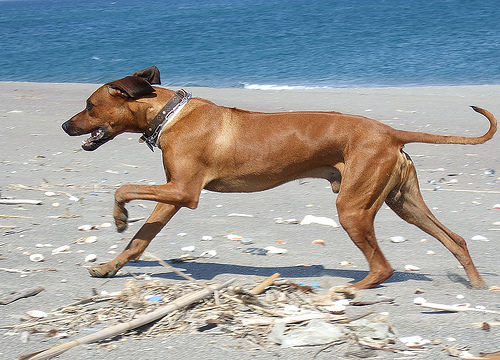

In [99]:
img

In [100]:
target

[tensor([ 4, 15,  6,  7,  8, 68,  4, 69]),
 tensor([ 4, 15,  6, 70,  4,  5, 71,  8, 22, 12, 69]),
 tensor([ 4,  6, 72, 73, 12, 74, 75, 12, 31]),
 tensor([15,  6,  8, 73, 12, 69]),
 tensor([12, 76, 15,  6,  7,  8, 73, 12, 69, 43, 12, 77])]

In [88]:
ar = [[eng(word) for word in sent] for sent in target]
torch.tensor(ar)

ValueError: expected sequence of length 12 at dim 1 (got 7)

In [89]:
import torch

captions = [torch.tensor([eng(word) for word in sent]) for sent in target]

In [90]:
captions

[tensor([ 4,  5,  6,  7,  8,  9,  4, 10,  6, 11, 12, 13]),
 tensor([ 5,  6, 14, 15,  6, 16, 13]),
 tensor([17, 18, 19, 20, 21, 22, 12, 23, 24]),
 tensor([17, 18, 25, 26, 11, 12, 13]),
 tensor([17, 18,  8, 16,  4, 27, 28, 29, 30, 31])]

In [209]:
def collate_fn(data):
    data_new = list()
    for img_id, img, sents in data:
        for sent in sents:
            data_new.append((img_id, img, sent))
    data = data_new
    data.sort(key=lambda x: len(x[2]), reverse=True)
    img_ids, imgs, sents = zip(*data)
    
    # Stack images
    imgs = torch.stack(imgs, 0)
    
    # merge captions
    caption_lengths = [ sent.size(0) for sent in   sents]

    # zero-matrix num_captions x caption_max_length
    padded_captions = torch.zeros(len(sents), max(caption_lengths)).long()

    # fill the zero-matrix with captions. the remaining zeros are padding
    for ix, sent in enumerate(sents):
        end = caption_lengths[ix]
        padded_captions[ix, :end] = sent[:end]
    
    return img_ids, imgs, padded_captions, caption_lengths

In [149]:
dataloader = torch.utils.data.DataLoader(dataset = dataset,
                                   batch_size = 5,
                                   shuffle = True,
                                   num_workers = 1,
                                   collate_fn = collate_fn)

NameError: name 'collate_fn' is not defined

In [212]:
dataloader = iter(dataloader)
next(dataloader)

(('2880874989_a33b632924.jpg',
  '495054019_3dee8a02f5.jpg',
  '2880874989_a33b632924.jpg',
  '495054019_3dee8a02f5.jpg',
  '367673290_f8799f3a85.jpg',
  '367673290_f8799f3a85.jpg',
  '495054019_3dee8a02f5.jpg',
  '2880874989_a33b632924.jpg',
  '2991771557_d98fa0a69f.jpg',
  '108898978_7713be88fc.jpg',
  '367673290_f8799f3a85.jpg',
  '108898978_7713be88fc.jpg',
  '495054019_3dee8a02f5.jpg',
  '2880874989_a33b632924.jpg',
  '367673290_f8799f3a85.jpg',
  '367673290_f8799f3a85.jpg',
  '2991771557_d98fa0a69f.jpg',
  '2991771557_d98fa0a69f.jpg',
  '108898978_7713be88fc.jpg',
  '108898978_7713be88fc.jpg',
  '108898978_7713be88fc.jpg',
  '495054019_3dee8a02f5.jpg',
  '2991771557_d98fa0a69f.jpg',
  '2880874989_a33b632924.jpg',
  '2991771557_d98fa0a69f.jpg'),
 tensor([[[[-0.0116,  0.0741,  0.0741,  ...,  0.8276,  0.7591,  0.7933],
           [ 0.0569,  0.0912,  0.0741,  ...,  0.8789,  0.7762,  0.7933],
           [ 0.0741,  0.0741,  0.0741,  ...,  0.8618,  0.7591,  0.7933],
           ...,
    

In [ ]:
def make_imagecaption_loader(dataset,
                             batch_size,
                             shuffle,
                             num_workers):
    

In [64]:
vocab.index2word(32)

## Building Eval loop

In [84]:
def convert_back_to_text(sample_ids: list, vocab: Lang):
    words = [vocab.index2word[word_id] for word_id in sample_ids]
    return ' '.join(words)

In [86]:
convert_back_to_text(sample_ids, vocab)

'awkwardly awkwardly awkwardly illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated illustrated'

In [8]:
batch_losses = list()
loss = 0
print('Runing Eval')
for i, (img_ids, imgs, captions, cap_lengths) in tqdm(enumerate(testDataloader), desc=loss, total=len(testDataloader)):
    with torch.no_grad():
        img_vecs = encoder(imgs)
        output, _ = decoder(img_vecs, captions.t(), cap_lengths)
        target = pack_padded_sequence(captions.t(), cap_lengths).data

        loss = criterion(output, target)
        batch_losses.append(loss.item())
        
print(sum(batch_losses)/len(batch_losses))

Runing Eval


NameError: name 'tqdm' is not defined

In [91]:
from tqdm import tqdm

## Building Sampler

In [9]:
import aeye.utils as utils

In [19]:
encoder_s, decoder_s, epoch, losses_t, losses_e = utils.load_model('saved_models/model-300-2020-04-21 08:57:41.313804.ckpt')

In [20]:
encoder.load_state_dict(encoder_s)
decoder.load_state_dict(decoder_s)

<All keys matched successfully>

In [13]:
from aeye import utils
cpu = torch.device('cpu')

In [21]:
import random

def sample(dataset, encoder, decoder, device, vocab): 
    idx = random.randint(0, len(dataset))
    img_id, img, captions = dataset[idx]
    imgs  = img.unsqueeze(0).to(device)
    img_vec = encoder.to(device)(imgs)
    output = decoder.to(device).sample(img_vec)
    output_sent = utils.convert_to_text(output, vocab)
    
    target_sents = list()
    for target in captions:
        target_sents.append(utils.convert_to_text(target.tolist(), vocab))
    print(output_sent, target_sents)
    

In [29]:
output_sent, target_sent

NameError: name 'output_sent' is not defined

In [23]:
predict(dataset_train,encoder, decoder, device, vocab)

SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS ['SOS two boys are standing on a balance beam while playing with a green rope EOS', 'SOS two boys holding a green rope and competing against each other on a balancing rod while others look on EOS', 'SOS two boys on a balance beam holding a rope EOS', 'SOS two kids are balancing on a log and holding a rope EOS', 'SOS two young boys playing a game on a log while other kids look on EOS']


In [26]:
captions.shape

NameError: name 'captions' is not defined

In [27]:
dataset_val[2]

('3695064885_a6922f06b2.jpg',
 tensor([[[-1.6042, -1.6555, -1.5870,  ..., -1.8953, -1.8782, -1.7754],
          [-1.6213, -1.5699, -1.4500,  ..., -1.4843, -1.5014, -1.5185],
          [-1.6213, -1.5014, -1.4158,  ..., -1.4672, -1.4329, -1.4158],
          ...,
          [ 0.2282,  0.0398, -0.0116,  ..., -0.0801,  0.0912, -0.1828],
          [ 0.0741,  0.1083, -0.0287,  ..., -0.2513, -0.0629, -0.2513],
          [ 0.2453,  0.1254, -0.0972,  ..., -0.3712, -0.0972, -0.1657]],
 
         [[-1.4230, -1.4755, -1.4055,  ..., -1.2129, -1.1078, -0.9328],
          [-1.4405, -1.3880, -1.2654,  ..., -1.3179, -1.3004, -1.2829],
          [-1.4405, -1.3179, -1.2304,  ..., -1.2654, -1.2654, -1.2654],
          ...,
          [ 0.4153,  0.2227,  0.1702,  ...,  0.0301,  0.2052, -0.0399],
          [ 0.2577,  0.2752,  0.1352,  ..., -0.1099,  0.1352, -0.0399],
          [ 0.4328,  0.3102,  0.0476,  ..., -0.2150,  0.1527,  0.0476]],
 
         [[-1.0376, -1.1247, -1.0724,  ..., -0.5670, -0.4624, -0.2707]

In [57]:
import datetime

x = datetime.datetime.now()
print('%s'%(x))

2020-04-20 23:41:35.869341
